In this file we try to train a ConvNet from scrach. 

In [1]:
%matplotlib inline

In [2]:
import os
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Lambda, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model, multi_gpu_model
import tensorflow as tf
from keras.callbacks import Callback, ModelCheckpoint, History, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from utils import plots

In [4]:
path = "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/UC_colonoscopy/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [5]:
batch_size=32
G = 4 # number of GPU's

In [6]:
train_datagen = ImageDataGenerator( 
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path+'split_patients/train/',  # this is the target directory
        target_size=(256, 320),  
        batch_size=batch_size*G,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        path+'split_patients/validation/',
        target_size=(256, 320),
        batch_size=batch_size*G,
        shuffle=False,
        class_mode='categorical')

Found 5895 images belonging to 4 classes.
Found 1538 images belonging to 4 classes.


In [ ]:
show_gen = ImageDataGenerator(rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        shear_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='nearest',).flow_from_directory(path+'split_patients/train/', target_size=(256, 320), class_mode='categorical', shuffle=True,
                                    batch_size=8)

In [12]:
show_batch, show_label = next(show_gen)

Found 5895 images belonging to 4 classes.


In [13]:
show_class = show_label.argmax(axis=1)

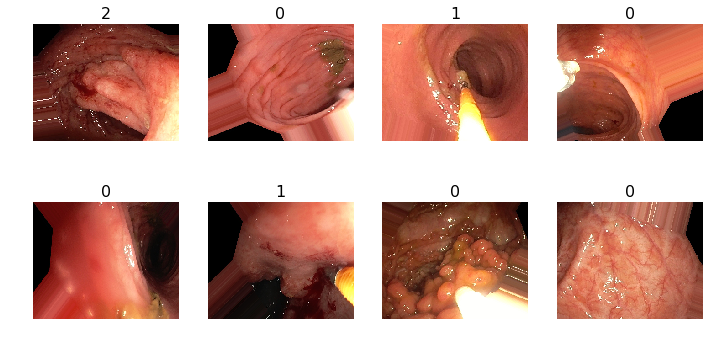

In [14]:
plots(show_batch, titles=show_class, rows=2)

## Model building and training

### Multi-GPU Model

In [11]:
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(341, 427, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())  
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
parallel_model = multi_gpu_model(model, gpus=G)

In [12]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
adam = Adam()
parallel_model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [8]:
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 512, 640, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 640, 3)  0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 640, 3)  0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 640, 3)  0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_4 (

### Single-GPU Model

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 320, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())  
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

In [5]:
adam = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [9]:
checkpointer = ModelCheckpoint(filepath=model_path+'scratch_shd0123.h5', verbose=0, save_best_only=True, save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1.e-7)

earlystop = EarlyStopping(patience=30)

In [13]:
history = parallel_model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples // (batch_size*G),
            epochs=300,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // (batch_size*G),
            callbacks = [checkpointer, reduce_lr, earlystop],
            verbose=1);

Epoch 1/300
46/46 [==============================] - 330s 7s/step - loss: 0.8171 - acc: 0.7550 - val_loss: 1.0924 - val_acc: 0.6562
Epoch 2/300
46/46 [==============================] - 327s 7s/step - loss: 0.6292 - acc: 0.7678 - val_loss: 1.2046 - val_acc: 0.6276
Epoch 3/300
46/46 [==============================] - 327s 7s/step - loss: 0.6079 - acc: 0.7611 - val_loss: 1.3328 - val_acc: 0.6556
Epoch 4/300
46/46 [==============================] - 328s 7s/step - loss: 0.5550 - acc: 0.7801 - val_loss: 1.4773 - val_acc: 0.6549
Epoch 5/300
46/46 [==============================] - 325s 7s/step - loss: 0.5090 - acc: 0.7957 - val_loss: 1.6499 - val_acc: 0.6491
Epoch 6/300
46/46 [==============================] - 325s 7s/step - loss: 0.5032 - acc: 0.7943 - val_loss: 1.9052 - val_acc: 0.6549
Epoch 7/300
46/46 [==============================] - 321s 7s/step - loss: 0.5210 - acc: 0.7954 - val_loss: 1.5209 - val_acc: 0.6523
Epoch 8/300
46/46 [==============================] - 318s 7s/step - loss: 0.

KeyboardInterrupt: 

In [18]:
history.history

{'acc': [0.72896563401374792, 0.7348908076073204, 0.73522938883040223],
 'loss': [4.2890150838845145, 4.2730552807906887, 4.2675980012066095],
 'lr': [0.001, 0.001, 0.001],
 'val_acc': [0.75679347826086951, 0.75679347826086951, 0.75679347826086951],
 'val_loss': [3.9200260069059394, 3.9200260069059394, 3.9200260069059394]}

In [26]:
with open('history_hd.pkl', 'wb') as f:
    pickle.dump(history.history, f, -1)

In [29]:
hist

{'acc': [0.72896563401374792, 0.7348908076073204, 0.73522938883040223],
 'loss': [4.2890150838845145, 4.2730552807906887, 4.2675980012066095],
 'lr': [0.001, 0.001, 0.001],
 'val_acc': [0.75679347826086951, 0.75679347826086951, 0.75679347826086951],
 'val_loss': [3.9200260069059394, 3.9200260069059394, 3.9200260069059394]}

## Result evaluation

In [8]:
with open('output/splitp0124.pkl', 'rb') as f:
    history = pickle.load(f)

In [11]:
history.keys()

dict_keys(['acc', 'val_loss', 'lr', 'loss', 'val_acc'])

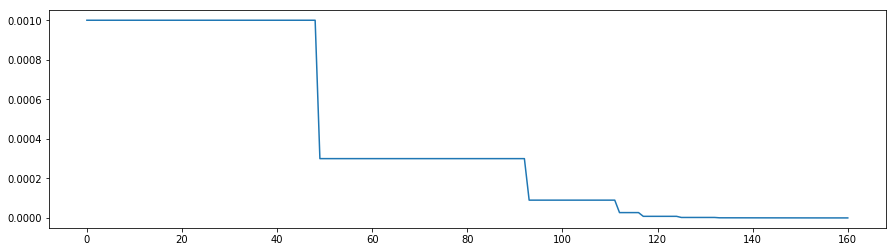

In [12]:
plt.figure(figsize=(15, 4))
plt.plot(history['lr'])

In [16]:
model.load_weights(model_path+'splitp0124f.h5')

In [17]:
y_pred = model.predict_generator(validation_generator)
y_pred_class = y_pred.argmax(axis=1)

In [18]:
sum(y_pred_class == 0), sum(y_pred_class == 1),sum(y_pred_class == 2), sum(y_pred_class == 3)

(1431, 63, 43, 1)

In [26]:
class_gen = test_datagen.flow_from_directory(
        path+'split_patients/validation/',
        target_size=(4, 5),
        batch_size=1538,
        shuffle=False,
        class_mode='categorical')
X_waste, y_true = next(class_gen)

Found 1538 images belonging to 4 classes.


In [27]:
y_true_class = y_true.argmax(axis=1)

In [28]:
np.save('y_true_class_sp.npy', y_true_class)

In [19]:
y_true_class = np.load('output/y_true_class_sp.npy')

In [46]:
y_true_class.shape

(1494,)

In [74]:
y_pred_class[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [20]:
df = pd.DataFrame(data=np.column_stack((y_true_class, y_pred_class)), columns=('true', 'pred'))

In [21]:
pd.crosstab(index=df.true, columns=df.pred, margins=True)

pred,0,1,2,3,All
true,,,,,
0,976,23,8,1,1008
1,243,19,2,0,264
2,153,14,29,0,196
3,59,7,4,0,70
All,1431,63,43,1,1538


In [58]:
pd.crosstab(index=df.true, columns=df.pred).apply(lambda r: r/r.sum(), axis=1)

pred,0,1,2,3
true,,,,
0,0.968582,0.025135,0.005386,0.000898
1,0.212963,0.745370,0.041667,0.000000
2,0.042735,0.059829,0.871795,0.025641
3,0.085106,0.042553,0.148936,0.723404
